In [1]:
from opnexrad import opnexrad
from opaod import *
from opaodbase import opaod_base
from opecmwf import *
from oppopdens import *
from oplandcover import *
from opsoil import *
from opglim import *
from oplith4 import *
from opgebco import *
from opsa import *
from opmodel import *
from opblh import match_blh


from OP_GOES_Download import *
from OP_ECMWF_Download import *
from OP_BLH_Download import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import os
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import pyart
import warnings
warnings.simplefilter('ignore')
import time
import importlib
import joblib
import datetime
import sys
%load_ext autoreload
%autoreload 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
##############################################################
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + datetime.timedelta(n)
##############################################################




base = "/home/xiaohe/Documents"
fname = os.path.join(base,'NEXRAD/AirNow/US_Boundary/USBoundary.shp')
projection_albert=ccrs.AlbersEqualArea()
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='none')



#     ax = plt.axes(projection=ccrs.PlateCarree())
#     ax.set_extent([80, 170, -45, 30])

Load Mdl
UTC input satrting time 2020-08-16T20:00
trim and grid AOD, save to df
-------4.519451379776001 seconds -------
retrieving landcover values from  geotiff file ......
There are 68681 sites macthed with the landcover raster, 5967 sites are out of coverage from raster
-------157.80125761032104 seconds -------
retrieving blh values from blh grid file ......
There are 49347 grid macthed with the ECMWF, 0 grid are out of coverage from blh
-------184.9852921962738 seconds -------
Loading ECMWF_Monthly/era5_US_Land_2020_08.grib
retrieving u10 values from ECMWF grid file ......
There are 46529 grid macthed with the ECMWF, 2818 grid are out of coverage from ECMWF
retrieving v10 values from ECMWF grid file ......
There are 46529 grid macthed with the ECMWF, 2818 grid are out of coverage from ECMWF
retrieving d2m values from ECMWF grid file ......
There are 46529 grid macthed with the ECMWF, 2818 grid are out of coverage from ECMWF
retrieving t2m values from ECMWF grid file ......
There a

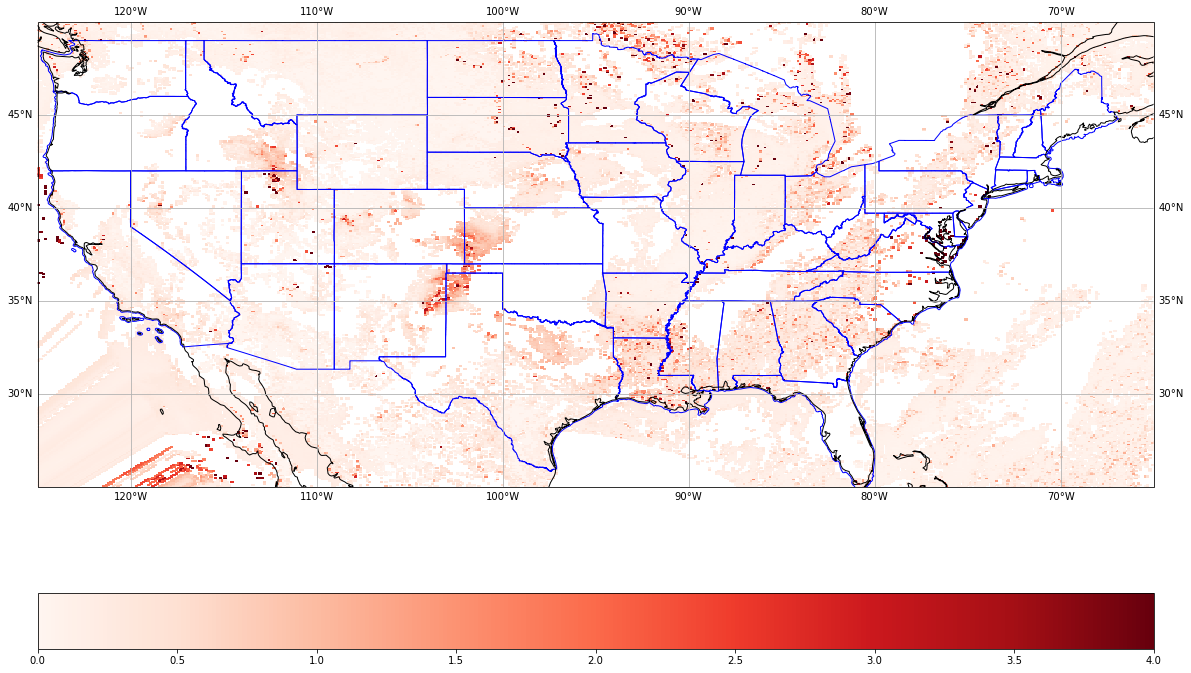

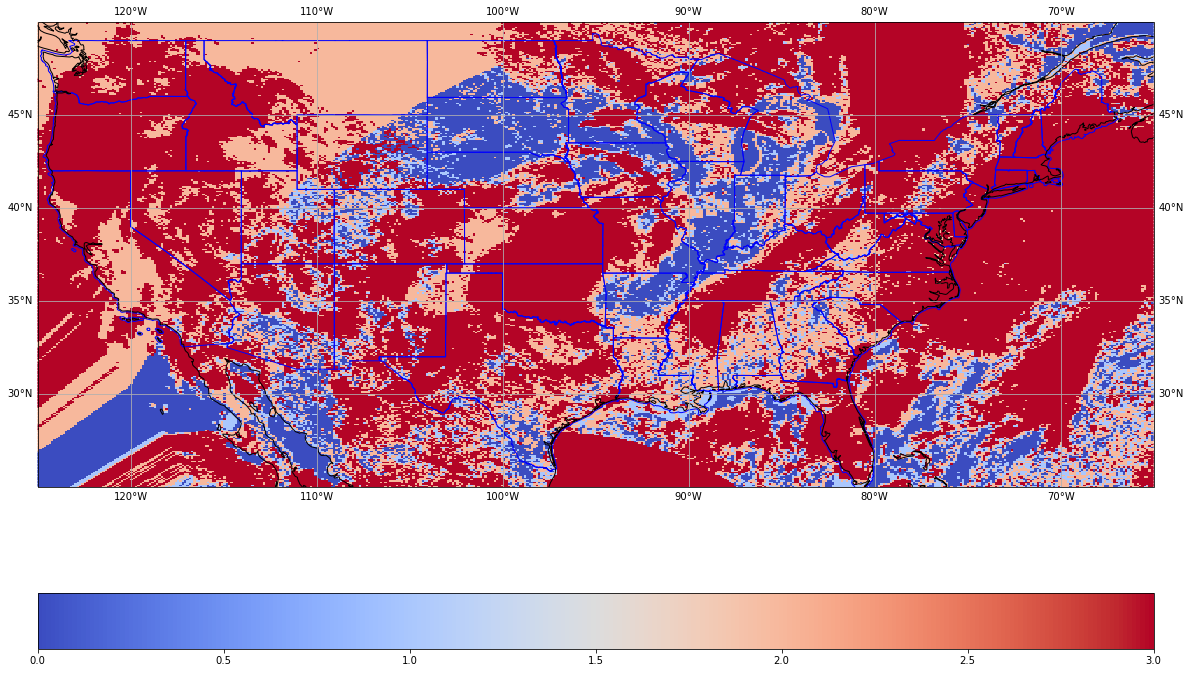

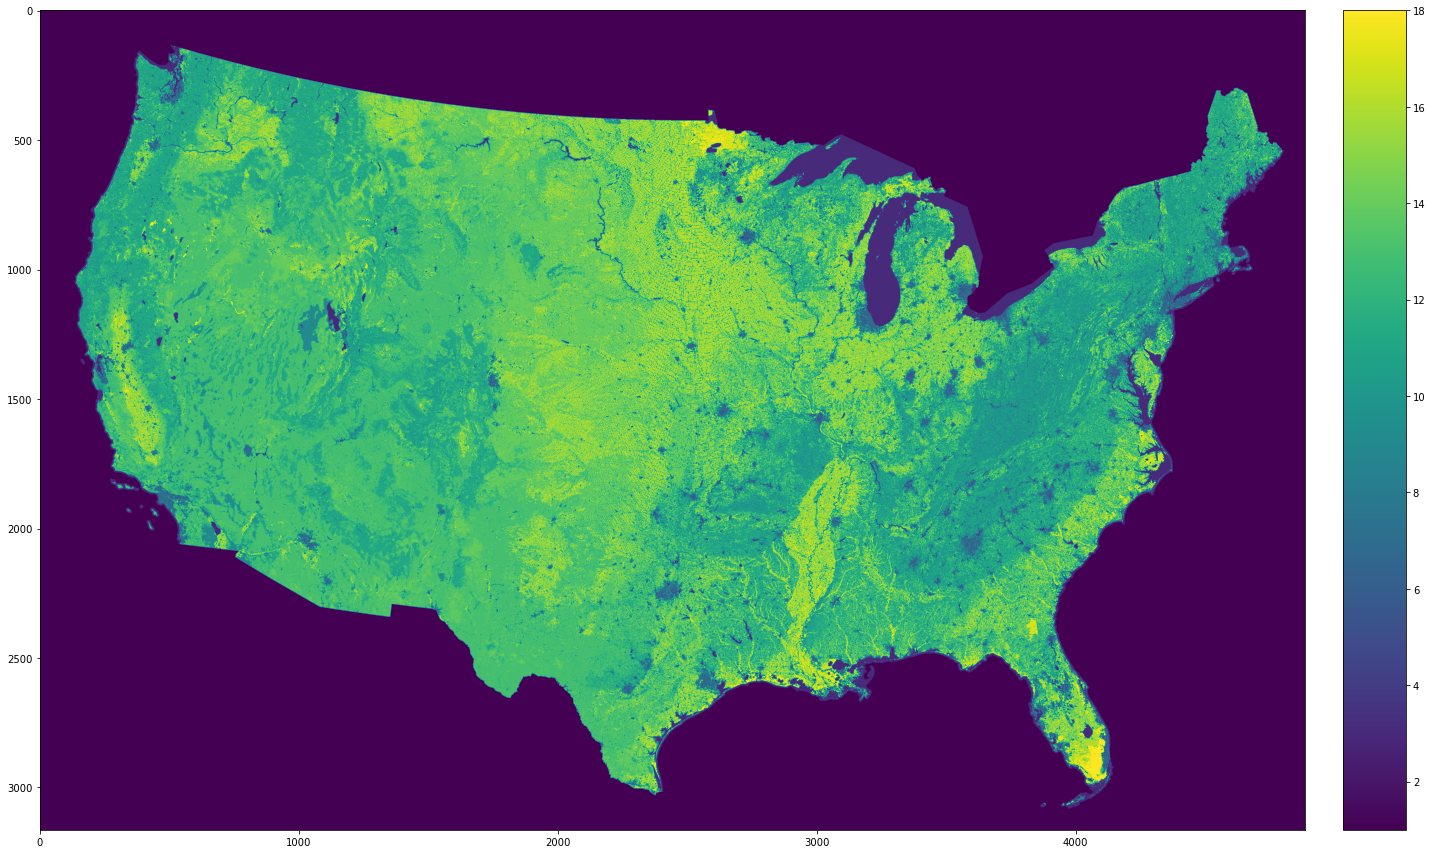

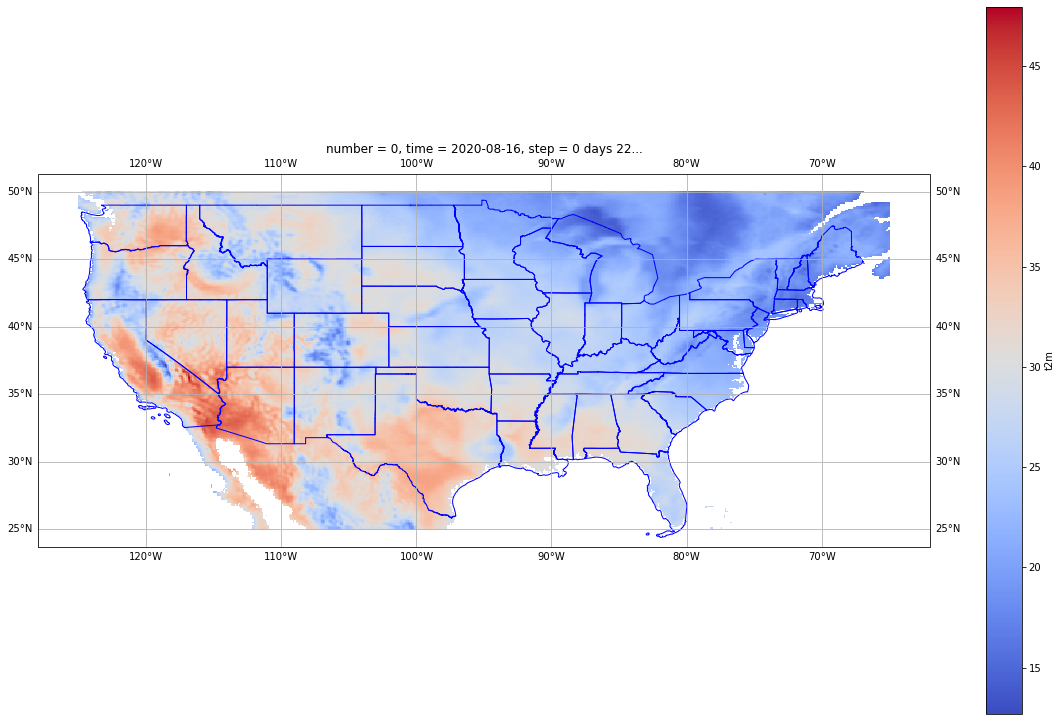

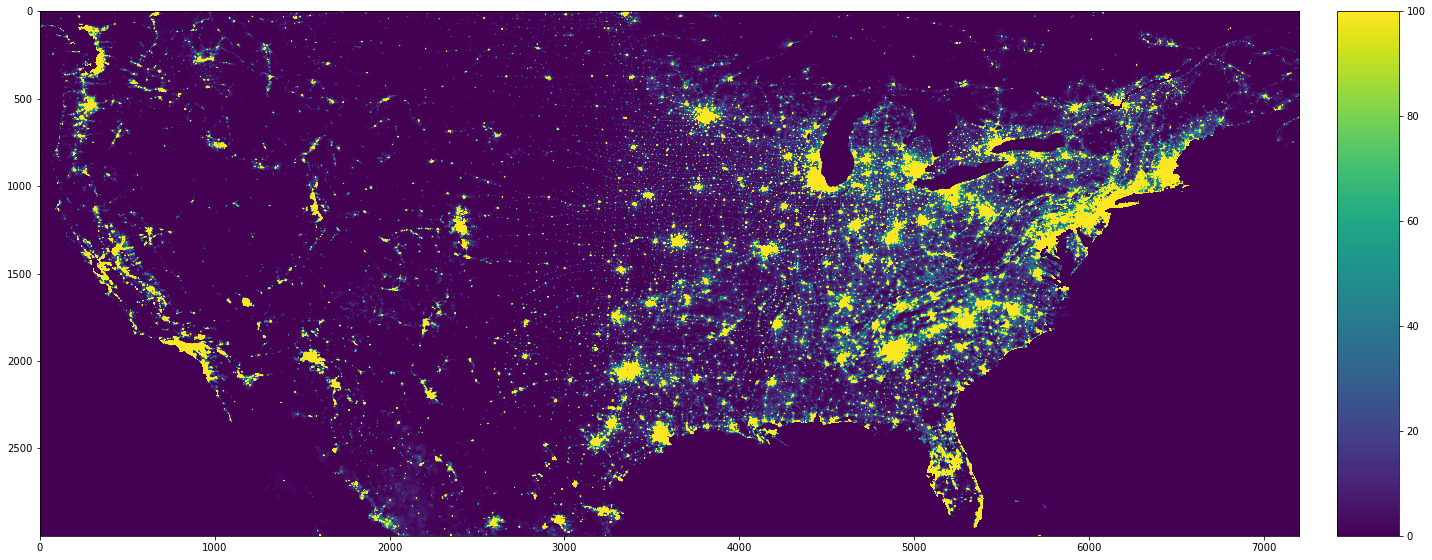

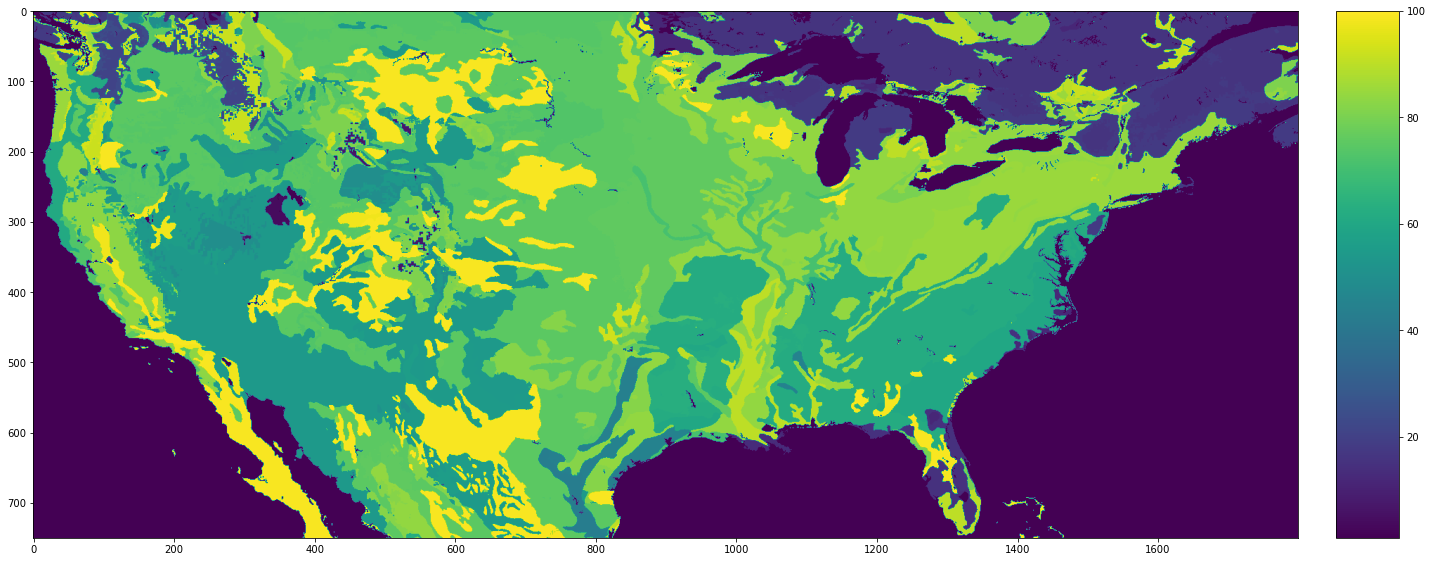

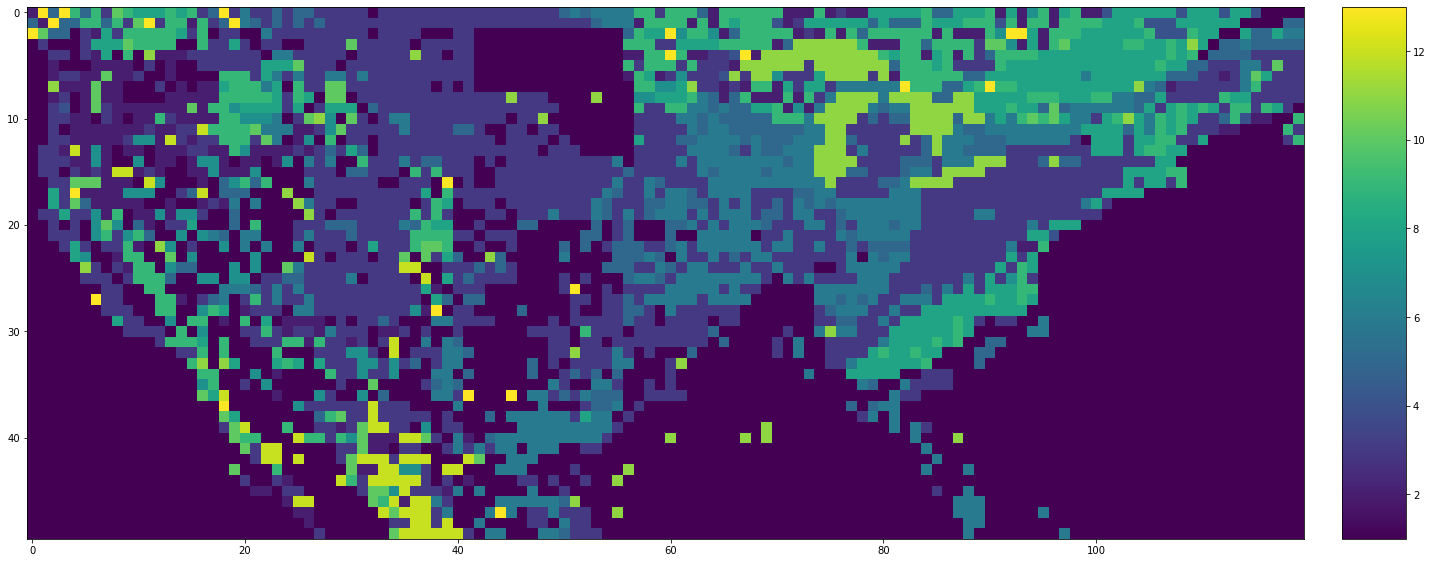

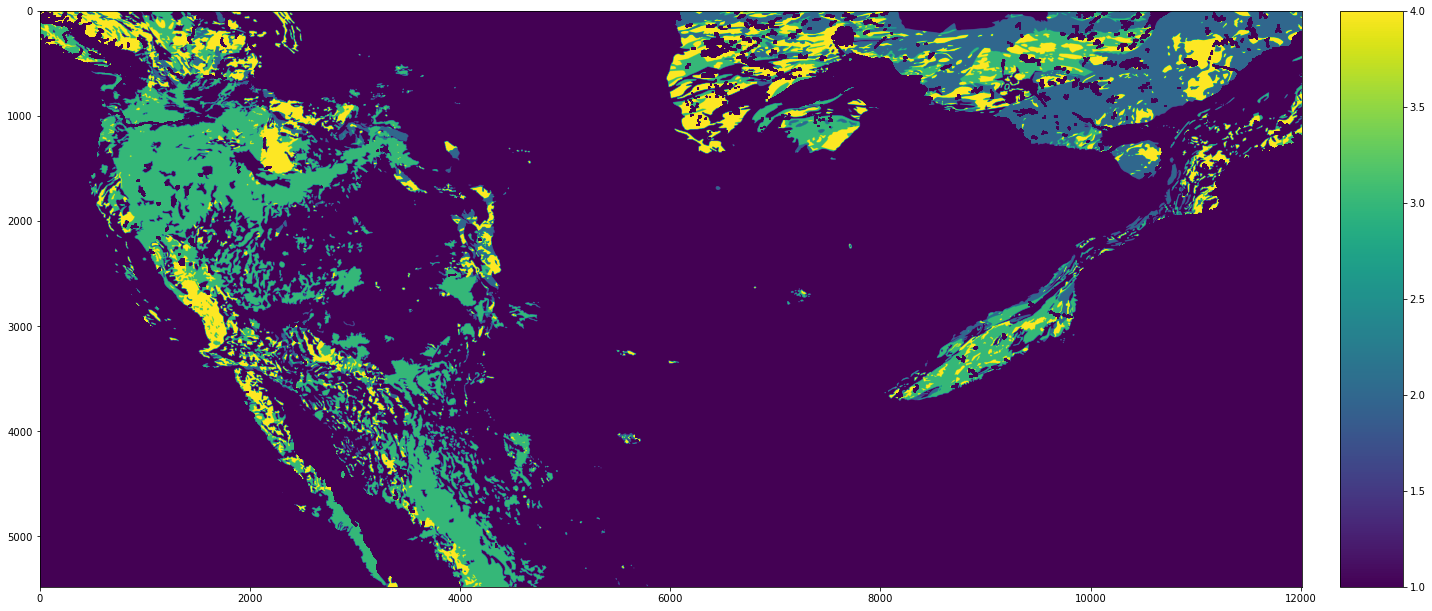

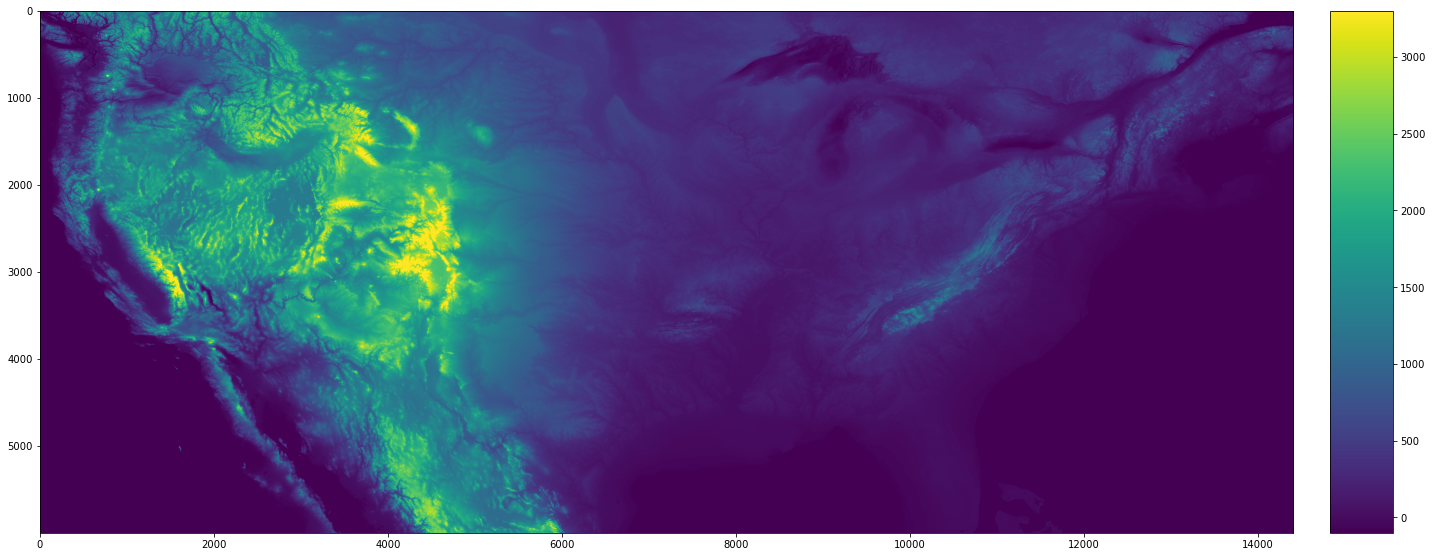

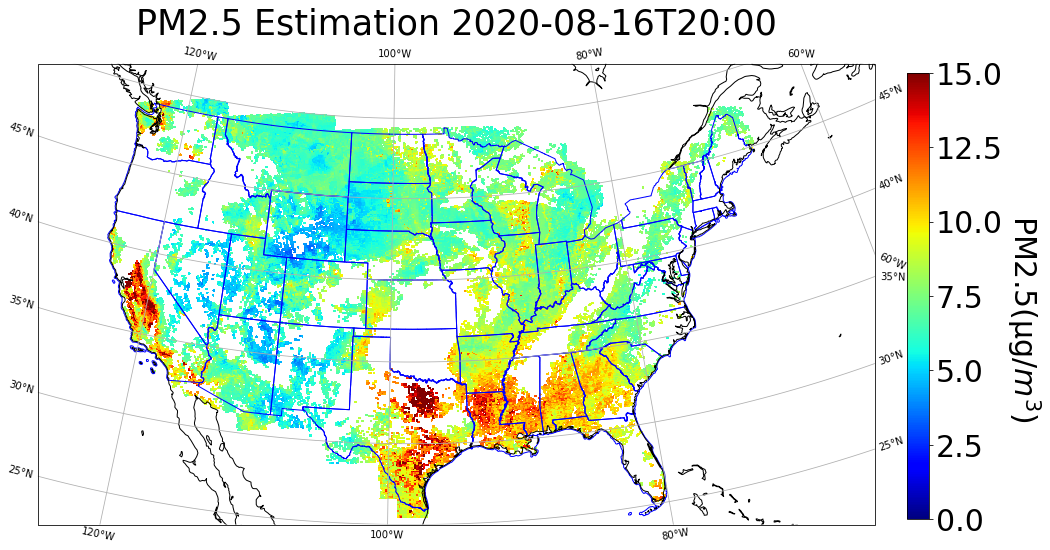

In [3]:
## Define plotting 
plot_variables = True # "yes" or "no"

print("Load Mdl")
Mdl = joblib.load(os.path.join(base,"NEXRAD/Model/ResidualAnalysis/US_AODDQF_SA_Z01_ET_Bayes_testMdl/ETreg_ECMWF_random.joblib"), mmap_mode=None)
predictors = [
       'uv10', 'd2m', 't2m', 'lai_hv', 'lai_lv', 'sp', 'sro', 'tp', 
       'popden', 'landcover', 'soil', 'glim', 'lith4', 'gebco','AOD','DQF','LZA','SZA','SAA']

# ## Set time range
# byr = int(sys.argv[1])
# bmon = int(sys.argv[2])
# bday = int(sys.argv[3])

# eyr = int(sys.argv[4])
# emon = int(sys.argv[5])
# eday = int(sys.argv[6])


start_dt = datetime.date(2020,8,16)  # custommized your starting date and end date here
end_dt = datetime.date(2020,8,16)



# Specify the time range 
# TimeRange = ['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00']
TimeRange = ['20:00']


for dt in daterange(start_dt, end_dt):
    for myTime in TimeRange:
        UTC_input = dt.strftime("%Y-%m-%dT") + myTime
        print("UTC input satrting time %s" %(UTC_input))



        UTC_format = '%Y-%m-%dT%H:%M'
        dt_object = datetime.datetime.strptime(UTC_input,UTC_format)
        in_year = datetime.datetime.strftime(dt_object, "%Y")
        in_month = datetime.datetime.strftime(dt_object, "%m")
        in_day = datetime.datetime.strftime(dt_object, "%d")
        in_hour = datetime.datetime.strftime(dt_object, "%H:00")

        try:
            AOD_path = download_goes(UTC_input)
        except:
            print(UTC_input + "download fail")
        

        AOD_list = sorted(glob.glob(AOD_path + "/*"))
        AOD_fn = AOD_list[int(len(AOD_list) / 2)]


        AOD_format = '%Y%j%H%M'
        time_str = os.path.basename(AOD_fn).split("_")[3][1:12]
        aod_dt_object = datetime.datetime.strptime(time_str,AOD_format)
        AOD_UTC = datetime.datetime.strftime(aod_dt_object, UTC_format)

####################################################################################################################


        mdl_type ="nonex"     #"nex" , "nonex" both nexrad and ecmwf, 

        if mdl_type == "nonex":


            ### AOD base  ################################################################################
            ds_GOES = xr.open_dataset(AOD_fn,decode_times=False)
            print("trim and grid AOD, save to df")
            if plot_variables:
                df_NG = opaod_base(UTC_input,ds_GOES,plotvar="yes",shape_feature=shape_feature)
            else:
                df_NG = opaod_base(UTC_input,ds_GOES,plotvar="no",shape_feature=shape_feature)
            full_extent = df_NG.iloc[:,0:2] # used as base for predicted data merge
            filter_NG = df_NG.dropna()



        elif mdl_type == "nex":
            print("Load Mdl")
            Mdl = joblib.load(os.path.join(base,"NEXRAD/Model/ResidualAnalysis/US_AODDQF_SA_Z01_ET_Bayes_testMdl/ETreg_random.joblib"), mmap_mode=None)


            predictors = [
                   'z01reflectivity', 'z01velocity',
                   'z01spectrum_width', 'z01differential_phase',
                   'z01differential_reflectivity', 'z01cross_correlation_ratio', 
                   'uv10', 'd2m', 't2m', 'lai_hv', 'lai_lv', 'sp', 'sro', 'tp', 
                   'popden', 'landcover', 'soil', 'glim', 'lith4', 'gebco','AOD','DQF','LZA','SZA','SAA']

            ## Read NEXRAD file and retrived irregular 2d coordinates
            
            nex_path = os.path.join("NEXRAD",datetime.datetime.strftime(dt_object, "%Y-%m"),
                                    datetime.datetime.strftime(dt_object, "%Y-%m-%d"),
                                    datetime.datetime.strftime(dt_object, "%H3000"),
                                    datetime.datetime.strftime(dt_object, "%Y-%m-%d-%H:3000") +".nc")
            try:
                grid = pyart.io.read_grid(nex_path)
            except:
                print("NEXRAD loading failed")
                continue
                                    
            NEXZ01, full_extent = opnexrad(grid,shape_feature,plotvar="reflectivity")

            ## AOD match ################################################################################
            filter_N = NEXZ01.dropna() # if nexrad is included


            start_time = time.time()
            nc_path = match_goes(filter_N,UTC_input)
            filter_NG = filter_N.dropna()
            print("-------%s seconds -------" %(time.time() - start_time))
            print("potting AOD")

            if plot_variables:
                aod_plot(nc_path,shape_feature,"AOD")

        #landcover##########################################################################################

        start_time = time.time()
        da = xr.open_rasterio("LandCover/Reclass_NLCD_Re1kmMajorit.tif")
        match_landcover(filter_NG,da)
        print("-------%s seconds -------" %(time.time() - start_time))

        if plot_variables:
            ## plot
            lc = xr.open_rasterio("LandCover/Reclass_NLCD_Re1kmMajorit.tif")
            fig = plt.figure(figsize=(20,13))
            ax = fig.add_subplot(111)
            im =ax.imshow(lc.variable.data[0],vmin=1,vmax=18)
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "5%", pad="3%")
            plt.colorbar(im, cax=cax)
            plt.tight_layout()
        #     plt.savefig("LandCover.png")
        filter_NG = filter_NG[filter_NG.landcover != 0]
        filter_NGL = filter_NG.dropna()
        
                ### BLH #######################################################################################
        try:
            # If ECMWF is not downloaded, you can use get data from ECMWF API. 
            # if ECMWF is downloaded through the code in PM25_DATASOURCE folder, you can read file locally

#             BLH_fn = download_BLH(UTC_input)
            first_half = ["01","02","03","04","05","06"]
            second_half = ["07","08","09","10","11","12"]
            if in_month in first_half:
                half = "1"
            else:
                half = "2" 
            BLH_fn = glob.glob('PBLH/era5_US_Single_' +in_year+'_' +half+'.grib')[0]
        except:
            print("######### BLH download failed, continue to the next datetime #######")
        #             print("\n")
        #             continue

        start_time = time.time()
        ds = xr.load_dataset(BLH_fn, engine='cfgrib')
        match_blh(filter_NGL,blh_xr=ds,stamp=UTC_input)
        filter_NGLB = filter_NGL.dropna()

        print("-------%s seconds -------" %(time.time() - start_time))

#         if plot_variables:
#         # plot emcwf
#             plot_2decmwf(ds,shape_feature)
        if len(filter_NGLB) ==0:
            print("####### 0 records, continue to the next datetime #######")
            continue





        ### ECMWF #######################################################################################
                # filter_NEG_PL.loc[filter_NEG_PL["landcover"]==0]
        try:
            # If ECMWF is not downloaded, you can use get data from ECMWF API. 
#             ECMWF_fn = download_ECMWF(UTC_input)
# if ECMWF is downloaded through the code in PM25_DATASOURCE folder, you can read file locally
            ECMWF_fn = glob.glob('ECMWF_Monthly/era5_US_Land_' +in_year+'_' +in_month+'.grib')[0]
        except:
            print("######### ECMWF download failed, continue to the next datetime #######")
            print("\n")
            continue
        
        start_time = time.time()
        print("Loading " + ECMWF_fn )
        ds = xr.load_dataset(ECMWF_fn, engine='cfgrib')
        match_ecmwf(filter_NGLB,ECMWF_xr=ds,stamp = UTC_input)
        filter_NGLBE = filter_NGLB.dropna()

        print("-------%s seconds -------" %(time.time() - start_time))

        if plot_variables:
        # plot emcwf
            plot_2decmwf(ds,shape_feature)
        if len(filter_NGLBE) ==0:
            print("####### 0 records, continue to the next datetime #######")
            continue

        filter_NGLBE["Month"] = int(datetime.datetime.strftime(dt_object, "%m"))

        ### popdens  ####################################################################################

        start_time = time.time()
        usda = combinetiff("PopDens/us_pop15.tif",
                          "PopDens/us_pop20.tif")
        # only support pop from 15 to 23
        match_popdens(filter_NGLBE,POPDEN_xr=usda, year=in_year)
        print("-------%s seconds -------" %(time.time() - start_time))

        if plot_variables:
        # ## plot pop dens tif
            da20 = xr.open_rasterio("PopDens/us_pop20.tif")
            fig = plt.figure(figsize=(20,13))
            ax = fig.add_subplot(111)
            im =ax.imshow(da20.variable.data[0],vmin=0,vmax=100)
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "5%", pad="3%")
            plt.colorbar(im, cax=cax)
            plt.tight_layout()
        #     plt.savefig("Popden2020.png")

        filter_NGLBE_P = filter_NGLBE.dropna()




        ### soil ##########################################################################################

        start_time = time.time()
        da = xr.open_rasterio("Soil/so2015v2.tif")
        print("Triming to US extent")
        da = da.where(da.y<50,drop=True).where(da.y>25,drop=True).where(da.x>-125,drop=True).where(da.x<-65,drop=True)
        match_soil(filter_NGLBE_P,da)
        print("-------%s seconds -------" %(time.time() - start_time))

        filter_NGLBE_PS = filter_NGLBE_P.dropna()
        if plot_variables:
            ## plot
            fig = plt.figure(figsize=(20,13))
            ax = fig.add_subplot(111)
            im =ax.imshow(da.variable.data[0],vmin=1,vmax=100)
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "5%", pad="3%")
            plt.colorbar(im, cax=cax)
            plt.tight_layout()
        #     plt.savefig("soil.png")



        ### glim ##########################################################################################

        start_time = time.time()
        da = xr.open_rasterio("GLiM/glim_wgs84_0point5deg.tif")
        print("Triming to US extent")
        da = da.where(da.y<50,drop=True).where(da.y>25,drop=True).where(da.x>-125,drop=True).where(da.x<-65,drop=True)
        match_glim(filter_NGLBE_PS,da)
        print("-------%s seconds -------" %(time.time() - start_time))

        filter_NGLBE_PSG = filter_NGLBE_PS.dropna()

        if plot_variables:
            ## plot
            fig = plt.figure(figsize=(20,13))
            ax = fig.add_subplot(111)
            im =ax.imshow(da.variable.data[0],vmin=1,vmax=13)
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "5%", pad="3%")
            plt.colorbar(im, cax=cax)
            plt.tight_layout()
        #     plt.savefig("glim.png")



        ### lith4 ##########################################################################################

        star_time = time.time()
        da = xr.open_rasterio("Lithology4Class/fullareagmnarocktypedecde.tif")
        match_lith4(filter_NGLBE_PSG, da)
        print("-------%s seconds -------" %(time.time() - start_time))

        filter_NGLBE_PSGL = filter_NGLBE_PSG.dropna()

        if plot_variables:
            ## plot
            fig = plt.figure(figsize=(20,13))
            ax = fig.add_subplot(111)
            im =ax.imshow(da.variable.data[0],vmin=1,vmax=4)
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "5%", pad="3%")
            plt.colorbar(im, cax=cax)
            plt.tight_layout()
        #     plt.savefig("lith4.png")



        ### gebco ##########################################################################################

        start_time = time.time()
        da = xr.open_rasterio("GEBCO_2020_tif/gebco_2020_n50.0_s25.0_w-125.0_e-65.0.tif")
        match_gebco(filter_NGLBE_PSGL, da)
        print("-------%s seconds -------" %(time.time() - start_time))

        filter_NGLBE_PSGLG = filter_NGLBE_PSGL.dropna()


        if plot_variables:
            ## plot
            fig = plt.figure(figsize=(20,13))
            ax = fig.add_subplot(111)
            im =ax.imshow(da.variable.data[0],vmin=-100,vmax=3300)
            divider = make_axes_locatable(plt.gca())
            cax = divider.append_axes("right", "5%", pad="3%")
            plt.colorbar(im, cax=cax)
            plt.tight_layout()
        #     plt.savefig("gebco.png")

        ### SA ##########################################################################################

        match_sa(filter_NGLBE_PSGLG,UTC = AOD_UTC)
        filter_NGLBE_PSGLGS = filter_NGLBE_PSGLG.dropna()
        # if plot_variables:
        #     plot_sa(filter_NEG_PLSGLGS,shape_feature,plotvar="SZA")

        ### Model ##########################################################################################
        out_df = modelPredict(UTC_input,mdl_type, filter_NGLBE_PSGLGS, full_extent, predictors, Mdl,shape_feature)
        print("\n")






        # # use 2km resoluation as base grid, need to regrid popdens landcover lith4 gebco to 2km grid

        # da20 = xr.open_rasterio("PopDens/us_pop20.tif")
        # ds = da20

        # xx, yy = np.meshgrid(ds.x.data, ds.y.data)

        # x_flat = xx.flatten()
        # y_flat = yy.flatten()
        # x_flat[x_flat<-125] = None
        # x_flat[x_flat>-65] = None
        # y_flat[y_flat>50] = None
        # y_flat[y_flat<25] = None


        # arr = ds.data
        # arr_flat = arr.flatten()

        # trimmed = pd.DataFrame()
        # trimmed["Latitude"] = y_flat
        # trimmed["Longitude"] = x_flat
        # trimmed["popdens"] = arr_flat

        # ## filter out None values which are outside US
        # trimmed_drop = trimmed.dropna(subset=["Latitude"])
        # trimmed_drop = trimmed_drop.dropna(subset=["Longitude"])

        # ## 10km grid which is the same as nexrad extent
        # xi = np.linspace(-125,-65,2400)
        # yi = np.linspace(25,50,1650)
        # xi,yi = np.meshgrid(xi,yi)

        # zi = griddata((trimmed_drop["Longitude"], trimmed_drop["Latitude"]),trimmed_drop["popdens"], (xi,yi), method='linear')

        # ds_NEXREG = xr.DataArray(zi, coords=[yi[:,1], xi[0]], dims=["lat", "lon"])

        # fig = plt.figure(figsize=[20,13])
        # ax = plt.subplot(projection=ccrs.PlateCarree())
        # ax.add_feature(shape_feature,edgecolor='blue')
        # ax.gridlines(draw_labels=True)
        # ax.coastlines()
        # ds_NEXREG.plot(cmap=plt.cm.Reds, vmin=0,vmax=100, x='lon', y='lat')
        # plt.savefig("poptestxrlinear.png")

In [ ]:
# ### Model ##########################################################################################
# out_df = modelPredict(UTC_input,mdl_type, filter_NGLBE_PSGLGS, full_extent, predictors, Mdl,shape_feature)
# print("\n")